### Importing the important libraries and dataset

To begin, import libraries like pandas and matplotlib/seaborn for data handling and visualization. Perform data preprocessing using NLTK, import email data from CSV file, and import machine learning algorithms like SVC, Random Forest, and Naive Bayes Classifier for model building.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import PIL

# model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# import warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mulombi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mulombi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mulombi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# importing the Dataset
data = pd.read_csv("emails_sample.csv",encoding='latin1')

In [4]:
data.sample(5)

v1                                                 v2 Unnamed: 2  \
3204  ham  Oh, yes, I've just been a little under the wea...        NaN   
2675  ham  I'm sick !! I'm needy !! I want you !! *pouts*...        NaN   
3476  ham  I got it before the new year cos yetunde said ...        NaN   
2540  ham  They said if its gonna snow, it will start aro...        NaN   
4339  ham  I want to sent  &lt;#&gt; mesages today. Thats...        NaN   

     Unnamed: 3 Unnamed: 4  
3204        NaN        NaN  
2675        NaN        NaN  
3476        NaN        NaN  
2540        NaN        NaN  
4339        NaN        NaN

### Initial Exploration And Data Cleaning

We will begin by performing an initial exploration and cleaning of the data to ensure we have a high-quality dataset for analysis.

In [5]:
data.shape

(5572, 5)

In [6]:
# remove unwanted columns
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [10]:
# rename columns to more intuitive names
data.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)

In [8]:
data.head(5)

v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

In [11]:
# get unique values for results columns
data['result'].value_counts()

result
ham     4825
spam     747
Name: count, dtype: int64

In [13]:
# check for missing values
data.isnull().sum()

result    0
emails    0
dtype: int64

In [12]:
# check for duplicates
data.duplicated().sum()

403

In [13]:
# remove duplicates
data = data.drop_duplicates(keep='first')

In [14]:
data.shape

(5169, 2)

### Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is a method used to analyze data on spam and regular emails. It involves comparing spam and ham emails, using pie charts, average length, word count, and sentence count, and using heatmaps for correlation.

 **1) Distribution of Labels**

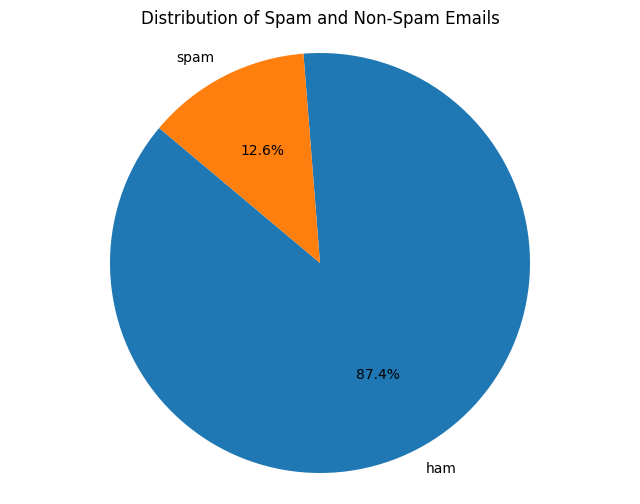

In [15]:
labels = data['result'].value_counts()

# Plotting 
plt.figure(figsize=(8, 6))
plt.pie(x=labels, labels=labels.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal')
plt.show()

As we can see from the above graph, the majority of emails in the dataset (87.4%) are categorized as ham, or non-spam, while only a smaller percentage (12.6%) are spam. This discrepancy matters since it influences our model's ability to identify spam emails. Given the large number of non-spam emails, the model may get skewed and overlook certain spam emails. To address this, we must train and test our model using certain methods. By doing this, we can ensure that our model is capable of identifying spam emails as well as non-spam emails, protecting our inboxes and preventing clutter.

In [16]:
data['length'] = [len(email) for email in data['emails']] # calculating length of each email
data['num_words'] = [len(word_tokenize(email)) for email in data['emails']] # calculating number of words in each email
data['num_sentence'] = [len(sent_tokenize(email)) for email in data['emails']] # calculating number of sentences in each email

In [17]:
data.head()

result                                             emails  length  \
0    ham  Go until jurong point, crazy.. Available only ...     111   
1    ham                      Ok lar... Joking wif u oni...      29   
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...     155   
3    ham  U dun say so early hor... U c already then say...      49   
4    ham  Nah I don't think he goes to usf, he lives aro...      61   

   num_words  num_sentence  
0         24             2  
1          8             2  
2         37             2  
3         13             1  
4         15             1

In [22]:
len(data.iloc[0]['emails'])

111

**2) Average Length of Emails for Spam and Ham**

In [18]:
# calculate average length of spam and ham emails
avg_length_spam = data[data['result'] == 'spam']['length'].mean()
avg_length_ham = data[data['result'] == 'ham']['length'].mean()
print(f"Average Length of Spam Emails: {avg_length_spam: .2f}")
print(f"Average Length of Ham Emails: {avg_length_ham: .2f}")

Average Length of Spam Emails:  137.89
Average Length of Ham Emails:  70.46


In [19]:
# plotting the bar graph
sns.barplot(
    x=['Spam', 'Ham'], 
    y=[avg_length_spam, avg_length_ham], 
    hue=['Spam', 'Ham'], 
    palette=['red', 'green'], 
    dodge=False, 
    legend=True
    )
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

The average length of spam emails is 137 characters, which is significantly longer than the average length of ordinary (ham) emails. Conversely, standard emails are substantially shorter, with an average of roughly 70 characters. This indicates that spam emails typically contain more content and are more wordy, perhaps in an effort to get your attention. Regular emails, such as those you receive for business or from friends, are typically brief and direct. Knowing this enables us to create more effective solutions for removing spam and maintaining the organization of our inboxes.

**3) Average Word of Emails for Spam and Ham**

In [20]:
#calculate average number of words in spam and ham emails
avg_word_spam = data[data['result'] == 'spam']['num_words'].mean()
avg_word_ham = data[data['result'] == 'ham']['num_words'].mean()
print(f"Average Words of Spam Emails: {avg_word_spam:.2f}")
print(f"Average Words of Ham Emails: {avg_word_ham:.2f}")

Average Words of Spam Emails: 27.67
Average Words of Ham Emails: 17.12


In [21]:
# Plotting the graph
sns.barplot(
    x=['Spam', 'Ham'], 
    y=[avg_word_spam, avg_word_ham], 
    hue=['Spam', 'Ham'], 
    palette=['red', 'green'], 
    dodge=False, 
    legend=True
    )
plt.title('Average Words of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Words')
plt.show()

The graph above shows that spam emails are typically longer—an average of almost 27 words. Regular ham emails, on the other hand, are shorter, with an average of only 17 words. This indicates that spam emails are typically longer, perhaps as a result of the ads or false information they contain. Regular emails, on the other hand, are clearer and more direct. Knowing this makes it simpler to locate the emails that are important to us and helps us develop stronger filters to remove spam and keep our inboxes clear of unsolicited messages.

**4) Average Sentence of Emails for Spam and Ham**

In [22]:
#calculate average number of sentences in spam and ham emails
avg_sentence_spam = data[data['result'] == 'spam']['num_sentence'].mean()
avg_sentence_ham = data[data['result'] == 'ham']['num_sentence'].mean()
print("Average Sentence of Spam Emails:", round(avg_sentence_spam, 2))
print("Average Sentence of Ham Emails:", round(avg_sentence_ham, 2))

Average Sentence of Spam Emails: 2.97
Average Sentence of Ham Emails: 1.82


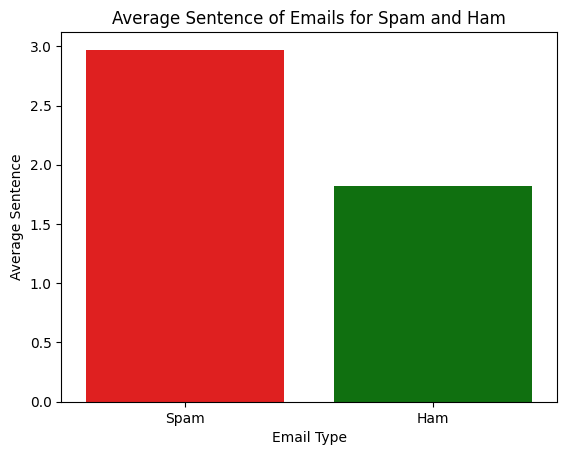

In [23]:
# Plotting the graph
sns.barplot(  
    x=['Spam', 'Ham'], 
    y=[avg_sentence_spam, avg_sentence_ham], 
    hue=['Spam', 'Ham'], 
    palette=['red', 'green'], 
    dodge=False, 
    legend=False)
plt.title('Average Sentence of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentence')
plt.show()

As can be seen from the accompanying graph, spam emails typically contain longer phrases than other types of emails. Regular emails often have two sentences, however spam emails typically contain three. This means that ordinary emails are typically shorter and more direct, but spam emails may be attempting to say more or persuade you of something. By being aware of this distinction, we can create more effective systems to identify and weed out spam emails, making our inboxes safer and cleaner for everyone to use.

**5) Relationship between Length and Spam**

In [29]:
# correlation coefficient between email length and spam classification
correlation = data['length'].corr((data['result'] == 'spam').astype(int))
print(correlation)

0.3847170667143065


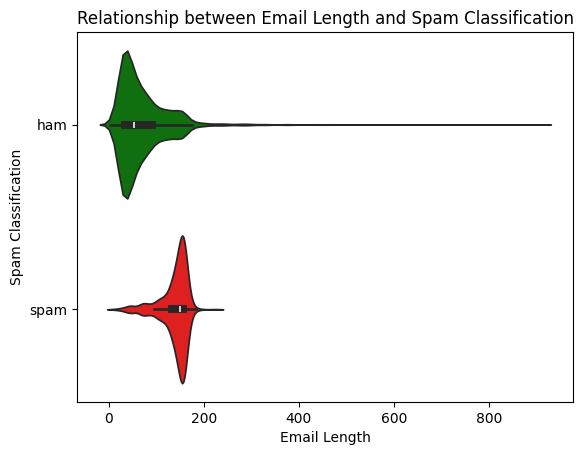

In [31]:
sns.violinplot(
    data=data, 
    x='length', 
    y='result', 
    hue='result', 
    palette=['green', 'red']
)
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()

We discovered that email length and spam classification have a positive correlation (correlation coefficient: 0.38). This indicates that spam emails are typically a little bit longer than non-spam emails. It is crucial to remember that the association is weak, suggesting that other factors might potentially affect whether an email is deemed spam. However, by taking into account email length as one of the criteria in the classification process, along with other pertinent factors, a knowledge of this link can aid in the improvement of spam detection algorithms.

**6) Relationship between Features**

In [24]:
#the relationship between features
correlation_matrix = data[['length', 'num_words', 'num_sentence']].corr()
print(correlation_matrix )

                length  num_words  num_sentence
length        1.000000   0.965760      0.624139
num_words     0.965760   1.000000      0.679971
num_sentence  0.624139   0.679971      1.000000


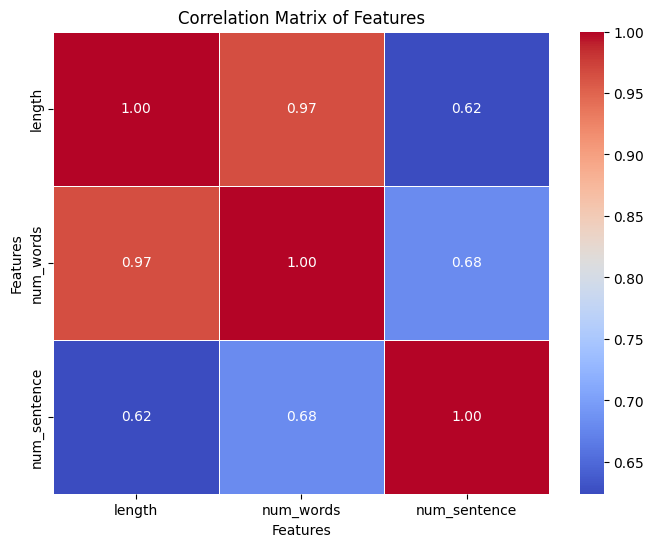

In [25]:
#visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

Strong positive relationships between email length and word count (0.97) and between word count and sentence count (0.68), according to the correlation matrix, are shown. This implies that emails that are longer typically contain more words, and emails that are longer typically contain more sentences. Nevertheless, there is a lesser (0.62) link between email length and sentence count. This suggests that although lengthier emails might contain more sentences, there is not as much of a correlation between the two. By comprehending these connections, we may better understand how various elements contribute to the overall composition and content of emails, which facilitates the classification of spam.

### Data Preprocessing

In [26]:
data['transform_text'] = [email.lower() for email in data['emails']]

# tokenization
data['transform_text'] = [word_tokenize(text) for text in data['transform_text']]

# removing special characters
data['transform_text'] = data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])

# removing stop words and punctuation
stop_words = set(stopwords.words('english'))
data['transform_text'] = data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

# stemming
ps = PorterStemmer()
data['transform_text'] = data['transform_text'].apply(lambda x: [ps.stem(word) for word in x])

# convert the preprocessed text back to string
data['transform_text'] = data['transform_text'].apply(lambda x: ' '.join(x))

In [27]:
# display the preprocessed data
data[['emails', 'transform_text']].head()

emails  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      transform_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4            nah nt think goe usf live around though

In [28]:
data.head()

result                                             emails  length  \
0    ham  Go until jurong point, crazy.. Available only ...     111   
1    ham                      Ok lar... Joking wif u oni...      29   
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...     155   
3    ham  U dun say so early hor... U c already then say...      49   
4    ham  Nah I don't think he goes to usf, he lives aro...      61   

   num_words  num_sentence                                     transform_text  
0         24             2  go jurong point crazi avail bugi n great world...  
1          8             2                              ok lar joke wif u oni  
2         37             2  free entri 2 wkli comp win fa cup final tkt 21...  
3         13             1                u dun say earli hor u c alreadi say  
4         15             1            nah nt think goe usf live around though

**7) Most Common Words in Spam Emails**

In [29]:
spam_emails = data[data['result'] == 'spam']['transform_text']

# tokenize the text in spam emails
spam_words = ' '.join(spam_emails).split()

#count occurrences of each word
word_counts = Counter(spam_words)

# find the most common words
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in Spam Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

# generate Word Cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf').generate_from_frequencies(dict(most_common_words)
)
    
# plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam Emails', fontname='DejaVu Sans')
plt.axis('off')

# plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Top 10 Most Common Words in Spam Emails:
call: 321 occurrences
free: 191 occurrences
2: 157 occurrences
txt: 141 occurrences
u: 135 occurrences
text: 122 occurrences
ur: 119 occurrences
mobil: 114 occurrences
stop: 106 occurrences
repli: 103 occurrences


ValueError: Only supported for TrueType fonts

Looking at the most common words found in spam emails, we see patterns that spammers often use to catch our attention or convince us to act. Words like "call," "free," and "txt" show up frequently, suggesting offers or requests for action. This helps us understand what to watch out for in our emails to avoid falling for spam. By knowing these common tricks, we can be more careful about which emails we open or respond to, keeping our inboxes safer. Email filters also use this information to better recognize and block spam messages, making our email experience more secure.

**8) Most Common Words in ham Emails**

In [30]:
ham_emails = data[data['result'] == 'ham']['transform_text']

# Tokenize the text in spam emails
ham_words = ' '.join(ham_emails).split()

# Count occurrences of each word
word_counts = Counter(ham_words)

# Find the most common words
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in ham Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in ham Emails')
plt.axis('off')

# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in ham Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Top 10 Most Common Words in ham Emails:
u: 904 occurrences
go: 404 occurrences
nt: 352 occurrences
get: 352 occurrences
2: 290 occurrences
gt: 288 occurrences
lt: 287 occurrences
come: 275 occurrences
ok: 251 occurrences
got: 238 occurrences


ValueError: Only supported for TrueType fonts

In non-spam emails, the following ten terms are most frequently used: "u," "go," "nt," "get," "2," "gt," "lt," "come," "ok," and "got." These words demonstrate how individuals communicate via emails, using abbreviations like "u" for "you" and "nt" for "not." They also disclose typical subjects like going somewhere or using "ok" to confirm something. Knowing these terms makes it easier to identify typical emails. It helps us identify odd or dubious messages, such as spam, by letting us know what to anticipate from everyday communications.

### Label Encoding

In [31]:
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'])

In [46]:
data.sample(5)

result                                             emails  length  \
122        1  Todays Voda numbers ending 7548 are selected t...     156   
4806       1  PRIVATE! Your 2004 Account Statement for 07849...     153   
3788       0              Are you sure you don't mean \get here      37   
4654       0  Our Prasanth ettans mother passed away last ni...      80   
1317       1  Win the newest ÛÏHarry Potter and the Order o...     140   

      num_words  num_sentence  \
122          29             2   
4806         29             3   
3788          9             1   
4654         16             2   
1317         30             1   

                                         transform_text  
122   today voda number end 7548 select receiv 350 a...  
4806  privat 2004 account statement 078498 7 show 78...  
3788                                   sure nt mean get  
4654  prasanth ettan mother pass away last night pra...  
1317  win newest harri potter order phoenix book 5 r...

### Model Building

In [32]:
# convert the input data into vector , so here we will use TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['transform_text']).toarray()
y = data['result']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
X.shape

(5169, 3000)

#### Model 1) SVC

In [36]:
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_svc))
print("Precision Score: ",precision_score(y_test,y_pred_svc))

SVM Accuracy: 0.98
confusion Matrix : [[889   0]
 [ 25 120]]
Precision Score:  1.0


#### Model 2) Random Forest classifier

In [37]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_rf))
print("Precision Score: ",precision_score(y_test,y_pred_rf))

Random Forest Accuracy: 0.98
confusion Matrix : [[888   1]
 [ 22 123]]
Precision Score:  0.9919354838709677


#### Model 3) Naive Bayes classifier

In [38]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_nb))
print("Precision Score: ",precision_score(y_test,y_pred_nb))

Naive Bayes Accuracy: 0.97
confusion Matrix : [[888   1]
 [ 25 120]]
Precision Score:  0.9917355371900827


#### Model 4) Logistic Regression

In [39]:
# train Logistic Regression model
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)

# print metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.2f}")
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_lr))
print("Precision Score:", precision_score(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.96
Confusion Matrix: [[883   6]
 [ 35 110]]
Precision Score: 0.9482758620689655


#### Model 5) KNeighborsClassifier

In [40]:
# train KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

# print metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.2f}")
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_knn))
print("Precision Score:", precision_score(y_test, y_pred_knn))

KNN Accuracy: 0.91
Confusion Matrix: [[889   0]
 [ 97  48]]
Precision Score: 1.0


In [41]:
# calculate precision scores for each classifier
precision_svc = precision_score(y_test, y_pred_svc)
precision_rf = precision_score(y_test, y_pred_rf)
precision_nb = precision_score(y_test, y_pred_nb)
precision_lr = precision_score(y_test, y_pred_lr)
precision_knn = precision_score(y_test, y_pred_knn)

# create lists to store accuracies and precision scores
classifiers = ['SVC', 'Random Forest', 'Naive Bayes', 'Logistic Regression', 'KNN']
accuracies = [accuracy_svc, accuracy_rf, accuracy_nb, accuracy_lr, accuracy_knn]
precision_scores = [precision_svc, precision_rf, precision_nb, precision_lr, precision_knn]

# create a DataFrame for plotting
results_df = pd.DataFrame({
    'Classifier': classifiers,
    'Accuracy': accuracies,
    'Precision': precision_scores
})

results_df

Classifier  Accuracy  Precision
0                  SVC  0.975822   1.000000
1        Random Forest  0.977756   0.991935
2          Naive Bayes  0.974855   0.991736
3  Logistic Regression  0.960348   0.948276
4                  KNN  0.906190   1.000000

In [42]:
# melt the DataFrame for seaborn
results_melted = results_df.melt(
    id_vars='Classifier', 
    value_vars=['Accuracy', 'Precision'], 
    var_name='Metric', value_name='Score'
    )

plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x='Classifier', y='Score', hue='Metric')
plt.ylim(0, 1)
plt.title('Classifier Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Classifier')
plt.legend(title='Metric')
plt.show()

SVC is the model that performs the best after sorting. Therefore, we will utilize SVC to forecast prices using svc.predict(). This procedure aids in the selection of the most predictive model.

### Model Prediction

In [43]:
new_emails = [
    "Get a free iPhone now!",
    "Hey, how's it going?",
    "Congratulations! You've won a prize!",
    "Reminder: Meeting at 2 PM tomorrow."
]

# Convert new data into numerical vectors using the trained tfidf_vectorizer
new_X = tfidf.transform(new_emails)
new_X_dense = new_X.toarray()

# Use the trained SVM model to make predictions
svm_predictions = svc_classifier.predict(new_X_dense)

# Print the predictions
for email, prediction in zip(new_emails, svm_predictions):
    if prediction == 1:
        print(f"'{email}' is predicted as spam.")
    else:
        print(f"'{email}' is predicted as ham.")

'Get a free iPhone now!' is predicted as ham.
'Hey, how's it going?' is predicted as ham.
'Congratulations! You've won a prize!' is predicted as spam.
'Reminder: Meeting at 2 PM tomorrow.' is predicted as ham.


### User Input Data Prediction

In [44]:
def predict_email(email):
    # Convert email into numerical vector using the trained TF-IDF vectorizer
    email_vector = tfidf.transform([email])

    # Convert sparse matrix to dense array
    email_vector_dense = email_vector.toarray()

    # Use the trained SVM model to make predictions
    prediction = svc_classifier.predict(email_vector_dense)

    # Print the prediction
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as ham.")

# sample user input for email
user_email = "Congratulations! You've won a prize!"

# Predict whether the input email is spam or ham
predict_email(user_email)

The email is predicted as spam.


In [ ]:
import joblib

# save the trained SVC model and TF-IDF vectorizer
joblib.dump(svc_classifier, 'svc_classifier_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# example: Load and use the model for prediction
loaded_model = joblib.load('svc_classifier_model.pkl')
loaded_tfidf = joblib.load('tfidf_vectorizer.pkl')

def predict_email_with_joblib(email):
    email_vector = loaded_tfidf.transform([email]).toarray()
    prediction = loaded_model.predict(email_vector)
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as ham.")

# Test with a sample email
predict_email_with_joblib("Congratulations! You've won a prize!")

The email is predicted as spam.


In [46]:
# export other trained models to .pkl files
joblib.dump(rf_classifier, 'random_forest_classifier_model.pkl')
joblib.dump(nb_classifier, 'naive_bayes_classifier_model.pkl')
joblib.dump(lr_classifier, 'logistic_regression_model.pkl')
joblib.dump(knn_classifier, 'knn_classifier_model.pkl')

['knn_classifier_model.pkl']